<a href="https://colab.research.google.com/github/anilkumarpanda/collections/blob/master/dscc_2019_workshop_fairness_full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DSCC 2019 Workshop - Fairness in Machine Learning and Data Science
**Authors**:
- Nguyen Tran: Nguyen.Tran@ing.com
- Eva van Weel: Eva.van.Weel@ing.com

This notebook provides an introduction to a preprocessing technique, [Reweighing](https://core.ac.uk/download/pdf/81728147.pdf), and an inprocessing technique, [Adversarial Debiasing](https://arxiv.org/pdf/1801.07593.pdf), to mitigate unwanted bias when training a machine learning model. The primary tool used during this workshop is [AI Fairness 360](https://github.com/IBM/AIF360), a Python package containing a wide range of algorithms to combat biases in data science workflows.

## AI Fairness 360 (AIF360) resources
- API documentation: https://aif360.readthedocs.io/en/latest/
- Github: https://github.com/IBM/AIF360
- Online interactive dashboard: http://aif360.mybluemix.net/data
- Paper: https://arxiv.org/pdf/1810.01943.pdf

## Import the AIF360 package

In [0]:
!git clone https://github.com/IBM/AIF360.git &>/dev/null
!pip install AIF360/ -r AIF360/requirements.txt &>/dev/null

import sys
sys.path.insert(1, "AIF360/")

In [0]:
# Import the necessary components
from aif360.datasets.standard_dataset import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.explainers.metric_text_explainer import MetricTextExplainer

# Reweighing
from aif360.algorithms.preprocessing import Reweighing

# Adversarial Debiasing
from aif360.algorithms.inprocessing import AdversarialDebiasing

## Download the dataset

We will be looking at the adult income dataset, where the task is to predict whether somebody has high or low income, given a wide range of demographic features.

Dataset reference: https://archive.ics.uci.edu/ml/datasets/adult

In [0]:
# Get the adult income dataset
!wget -P AIF360/aif360/data/raw/adult/ https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data &>/dev/null
!wget -P AIF360/aif360/data/raw/adult/ https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test &>/dev/null
!wget -P AIF360/aif360/data/raw/adult/ https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names &>/dev/null

## Standard imports

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import MaxAbsScaler

In [0]:
import warnings
warnings.filterwarnings('ignore')

## Read the income dataset

In [0]:
column_names = ['age', 'workclass', 'fnlwgt', 'education',
      'education-num', 'marital-status', 'occupation', 'relationship',
      'race', 'gender', 'capital-gain', 'capital-loss', 'hours-per-week',
      'native-country', 'income-per-year']

df_orig = pd.read_csv("AIF360/aif360/data/raw/adult/adult.data", 
                   header=None, names=column_names,
                   skipinitialspace=True, na_values=['?'])
df_orig['high-income'] = df_orig['income-per-year'].replace({'<=50K': 0, '>50K': 1})
df_orig = df_orig.drop(["fnlwgt", "education-num", 'income-per-year'], axis=1)

In [0]:
df_orig.head()

,age,workclass,education,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,high-income
0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [0]:
print(f"Number of rows: {len(df_orig)}")
print("Number of unique values of each column:")
for col in df_orig.columns:
  print(f" + {col}: {df_orig[col].nunique()}")

Number of rows: 32561
Number of unique values of each column:
 + age: 73
 + workclass: 8
 + education: 16
 + marital-status: 7
 + occupation: 14
 + relationship: 6
 + race: 5
 + gender: 2
 + capital-gain: 119
 + capital-loss: 92
 + hours-per-week: 94
 + native-country: 41
 + high-income: 2


In [0]:
numerical_columns = ['age', 'capital-gain', 'capital-loss', 'hours-per-week']
categorical_columns = ['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'gender', 'race', 'native-country']

## Scale down numerical features

Transform the `age`, `capital-gain`, `capital-loss` and `hours-per-week` features by scaling them down by their max values.

In [0]:
df_scaled = df_orig.copy()

In [0]:
min_max_scaler = MaxAbsScaler()

for c in numerical_columns:
  df_scaled[c] = min_max_scaler.fit_transform(df_scaled[[c]])

In [0]:
df_scaled.head()

,age,workclass,education,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,high-income
0,0.433333,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.404040,United-States,0
1,0.555556,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.00000,0.0,0.131313,United-States,0
2,0.422222,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.00000,0.0,0.404040,United-States,0
3,0.588889,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.00000,0.0,0.404040,United-States,0
4,0.311111,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.00000,0.0,0.404040,Cuba,0


## Define parameters to setup AIF360

AIF360's dataset API requires a number of pre-defined arguments, such as the name of the label column, and the value of the favorable class.

In this workshop, the label `high-income` has value of `1` if the income of an individual is higher than $50,000 annually, and `0` otherwise. Therefore, `1` is our favorable class.

In [0]:
label_column='high-income'
favorable_classes=[1]

## Specifying the privileged group

---

The code block in this section specifies `male` as the privileged `gender`.

In [0]:
# To specify another privileged group, replace `gender` with another feature column
# and Replace `Male` with another privileged value
protected_attribute_names= ['gender']  
privileged_classes= [['Male']] 

Use the variable `df_orig` to perform any initial analyses you need in order to identify another privileged group for [Exercise 5](#scrollTo=p8HRa8LKCN-6&line=3&uniqifier=1).

In [0]:
df_orig.sample(5)

,age,workclass,education,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,high-income
10410,28,Self-emp-not-inc,11th,Never-married,Craft-repair,Not-in-family,White,Male,0,0,40,Mexico,0
27559,49,Private,7th-8th,Divorced,Craft-repair,Not-in-family,White,Male,0,0,70,United-States,0
5935,29,Private,Bachelors,Never-married,Adm-clerical,Not-in-family,Black,Female,0,0,40,United-States,0
27192,34,Private,Some-college,Married-civ-spouse,Exec-managerial,Wife,White,Female,7688,0,50,United-States,1
3588,74,NaN,Some-college,Widowed,NaN,Not-in-family,White,Female,0,0,12,United-States,0


---

In [0]:
# Do not change this block. They are needed for AIF360 APIs.
privileged_groups = [{k: 1 for k in protected_attribute_names}]
unprivileged_groups = [{k: 0 for k in protected_attribute_names}]

## One-hot encode categorical features

In [0]:
df = pd.get_dummies(df_scaled, columns=[col for col in categorical_columns if col not in protected_attribute_names], drop_first=True)

## Train Test split

Split the data into train and test sets with 3:1 ratio. Stratification is done on the `high-income` label.

In [0]:
train_columns = [col for col in df.columns if col != label_column]

In [0]:
df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(df[train_columns], df[label_column], test_size=0.25, random_state=1, stratify=df[label_column])

In [0]:
df_train = df_X_train.copy()
df_train[label_column] = df_y_train

df_test = df_X_test.copy()
df_test[label_column] = df_y_test

## Transform pandas dataframes to AIF360's `StandardDataset` objects

Construct `StandardDataset` objects from pandas dataframes. Most functions and methods of AIF360 do not interact directly with pandas dataframes, rather they expect `Dataset` objects.

In [0]:
dataset_full = StandardDataset(
    df=df, label_name=label_column,
    favorable_classes=favorable_classes,
    protected_attribute_names=protected_attribute_names,
    privileged_classes=privileged_classes,
    categorical_features=[],
    features_to_keep=[],
    features_to_drop=[]
)

dataset_train = StandardDataset(
    df=df_train, label_name=label_column,
    favorable_classes=favorable_classes,
    protected_attribute_names=protected_attribute_names,
    privileged_classes=privileged_classes,
    categorical_features=[],
    features_to_keep=[],
    features_to_drop=[]
)

dataset_test = StandardDataset(
    df=df_test, label_name=label_column,
    favorable_classes=favorable_classes,
    protected_attribute_names=protected_attribute_names,
    privileged_classes=privileged_classes,
    categorical_features=[],
    features_to_keep=[],
    features_to_drop=[]
)

[`Metric`](https://aif360.readthedocs.io/en/latest/modules/metrics.html) classes of AIF360, such as `BinaryLabelDatasetMetric`, contain useful statistics for one or more `Dataset` objects.

In [0]:
dataset_full_stats = BinaryLabelDatasetMetric(dataset_full, privileged_groups=privileged_groups, unprivileged_groups=unprivileged_groups)
dataset_train_stats = BinaryLabelDatasetMetric(dataset_train, privileged_groups=privileged_groups, unprivileged_groups=unprivileged_groups)
dataset_test_stats = BinaryLabelDatasetMetric(dataset_test, privileged_groups=privileged_groups, unprivileged_groups=unprivileged_groups)

For example, we can check `statistical parity` using the `mean_difference()` method:

In [0]:
dataset_train_stats.statistical_parity_difference()

-0.19257229463589692

AIF360 also provides [`Explainer`](https://aif360.readthedocs.io/en/latest/modules/explainers.html) classes, which will print out human-readable descriptions for each metric/statistic.

In [0]:
explainer_full = MetricTextExplainer(dataset_full_stats)
explainer_train = MetricTextExplainer(dataset_train_stats)
explainer_test = MetricTextExplainer(dataset_test_stats)

In [0]:
explainer_train.statistical_parity_difference()

'Statistical parity difference (probability of favorable outcome for unprivileged instances - probability of favorable outcome for privileged instances): -0.19257229463589692'

## Preprocessing with reweighing

[Reweighing](https://core.ac.uk/download/pdf/81728147.pdf) is a preprocessing technique that aims to assign a weight to each data point so that during model training, the training loss is amplified differently for each of them.

Weights are assigned based on the discrepancy between expected occurrences and actual occurrences for each group. 

For example, assuming we have a dataset where 50% of the data points have positive labels, and 30% have `male` as `gender`, then the expected percentage of positive, male samples should be $0.3 \times 0.5 = 0.15$, meaning 15%. If the actual percentage of such samples is 20%, then the weight for these data points will be $\dfrac{0.15}{0.2} = 0.75$. These points are then given less importance by the machine learning model.

In [0]:
rw = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

### Exercise 1 - Determine sample weights

#### Exercise 1.1 - Fitting

**Hint**: Look at the [API doc for the `fit` method](https://aif360.readthedocs.io/en/latest/modules/preprocessing.html#aif360.algorithms.preprocessing.Reweighing.fit). Use it to fit the reweighing object `rw` on `dataset_train`.

In [0]:
rw.fit(dataset_train)

#### Exercise 1.2 - Transforming

Use the [`transform` method](https://aif360.readthedocs.io/en/latest/modules/preprocessing.html#aif360.algorithms.preprocessing.Reweighing.transform) of `rw` object to transform the training data, effectively creating a new dataset with weights information attached.

In [0]:
dataset_train_rw = rw.transform(dataset_train)

### Exercise 1 - Solution
Click below for the solution.

```python
# 1.1
rw.fit(dataset_train)

# 1.2
dataset_train_rw = rw.transform(dataset_train)
```

### Train a classifier on original training data

First we fit a Logistic Regression model on the training dataset.

In [0]:
clf_lr_plain = LogisticRegression()

clf_lr_plain.fit(dataset_train.features, dataset_train.labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Then we obtain the predictions in terms of probabilities.

In [0]:
y_test_plain_proba = clf_lr_plain.predict_proba(dataset_test.features)[:, favorable_classes[0]]

### Train a classifier on weighed training data

We define another Logistic Regression model, and also extract the weights from `dataset_train_rw`.

In [0]:
clf_lr_rw = LogisticRegression()
sample_weights = dataset_train_rw.instance_weights

### Exercise 2 - Fit the Logistic Regression on training data but with sample weights

Have a look at the [API for the `fit` method](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.fit) of Logistic Regression. Use it to train a Logistic Regression model while taking sample weights into account.

**Hint**: The training dataset to be used is `dataset_train_rw`. Moreover, have a look at how we fit the plain classifier in the [Train a classifier on original training data](#scrollTo=wDs9U7gQDzdy&line=3&uniqifier=1) sub-section. Note that the `sample_weights` we defined in the [previous block](#scrollTo=jpeCbrTHFzvC) should now be used.

In [0]:
clf_lr_rw.fit(dataset_train_rw.features, dataset_train_rw.labels, sample_weight=dataset_train_rw.instance_weights)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

### Exercise 2 - Solution
Click below for the solution.

```python
# 2
clf_lr_rw.fit(dataset_train_rw.features, dataset_train_rw.labels, sample_weight=dataset_train_rw.instance_weights)
```

### Make predictions on test set using the trained classifier on data with reweighing

In [0]:
y_test_rw_proba = clf_lr_rw.predict_proba(dataset_test.features)[:, favorable_classes[0]]

### Collect classification and fairness metric

Because our model outputs probabilities, we can experiment with different thresholds to use for classification, and observe how that affects model performance.

[Balanced accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html) is used as the classification metric in this demonstration. The fairness metrics collected are statistical parity difference and [equal opportunity diffference](https://arxiv.org/pdf/1610.02413.pdf).

In [0]:
classification_thresholds_list = np.linspace(0.01, 0.99, 100)
balanced_accuracy_plain_list = []
balanced_accuracy_rw_list = []

average_odds_diff_plain = []
average_odds_diff_rw = []

statistical_parity_diff_plain = []
statistical_parity_diff_rw = []

for threshold in classification_thresholds_list:
  # Plain model
  y_test_plain = (y_test_plain_proba >= threshold).astype(float)
  balanced_accuracy_plain_list.append(balanced_accuracy_score(dataset_test.labels, y_test_plain))
  dataset_test_plain_model = dataset_test.copy(deepcopy=True)
  dataset_test_plain_model.labels = y_test_plain[:, np.newaxis]
  
  cm_plain = ClassificationMetric(
      dataset_test, 
      dataset_test_plain_model, 
      unprivileged_groups=unprivileged_groups, 
      privileged_groups=privileged_groups
  )
  average_odds_diff_plain.append(np.abs(cm_plain.equal_opportunity_difference()))
  statistical_parity_diff_plain.append(np.abs(cm_plain.statistical_parity_difference()))
  
  
  # Model on reweighed data
  y_test_rw = (y_test_rw_proba >= threshold).astype(float)
  dataset_test_rw_model = dataset_test.copy(deepcopy=True)
  dataset_test_rw_model.labels = y_test_rw[:, np.newaxis]
  balanced_accuracy_rw_list.append(balanced_accuracy_score(dataset_test.labels, y_test_rw))
  cm_rw = ClassificationMetric(
      dataset_test, 
      dataset_test_rw_model, 
      unprivileged_groups=unprivileged_groups, 
      privileged_groups=privileged_groups
  )
  average_odds_diff_rw.append(np.abs(cm_rw.equal_opportunity_difference()))
  statistical_parity_diff_rw.append(np.abs(cm_rw.statistical_parity_difference()))

Next, we plot the classification and fairness metrics to compare with versus without reweighing.

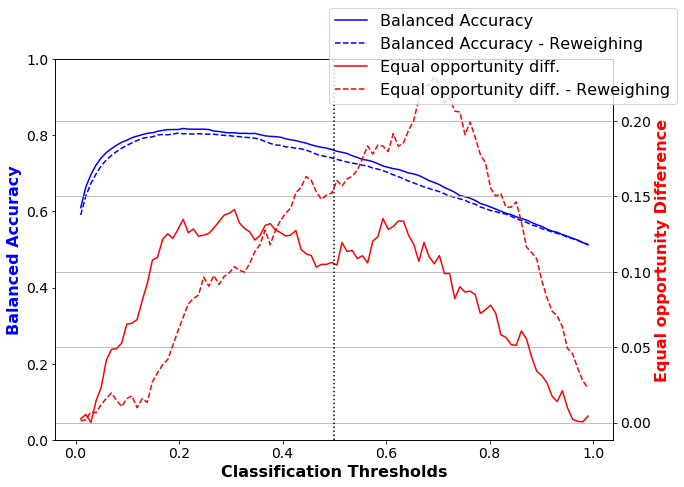

In [0]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.set_ylim(0, 1)
ax1.plot(classification_thresholds_list, balanced_accuracy_plain_list, color='b')
ax1.plot(classification_thresholds_list, balanced_accuracy_rw_list, color='b', linestyle='dashed')
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(classification_thresholds_list, average_odds_diff_plain, color='r')
ax2.plot(classification_thresholds_list, average_odds_diff_rw, color='r', linestyle='dashed')
ax2.set_ylabel('Equal opportunity Difference', color='r', fontsize=16, fontweight='bold')
ax2.axvline(0.5, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

fig.legend(["Balanced Accuracy", "Balanced Accuracy - Reweighing",
            "Equal opportunity diff.", "Equal opportunity diff. - Reweighing"], 
           fontsize=16, loc='best')

The dotted vertical line on the plot above represents the typical classification threshold at 0.5. **What are your thoughts looking at the plot?**

---

Finally, we look also at statistical parity difference.

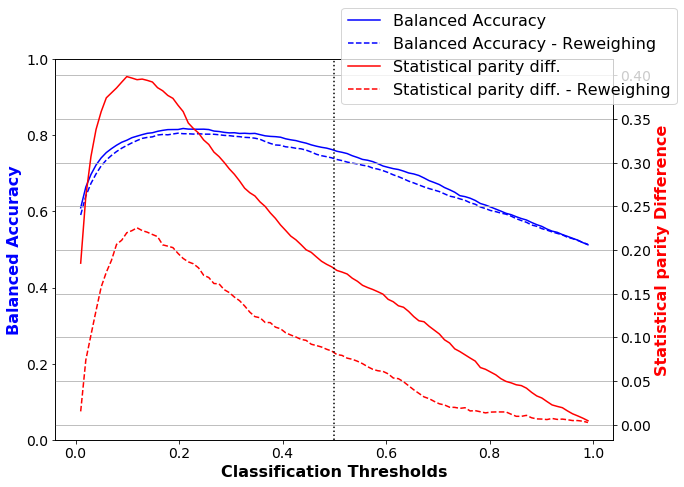

In [0]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.set_ylim(0, 1)
ax1.plot(classification_thresholds_list, balanced_accuracy_plain_list, color='b')
ax1.plot(classification_thresholds_list, balanced_accuracy_rw_list, color='b', linestyle='dashed')
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(classification_thresholds_list, statistical_parity_diff_plain, color='r')
ax2.plot(classification_thresholds_list, statistical_parity_diff_rw, color='r', linestyle='dashed')
ax2.set_ylabel('Statistical parity Difference', color='r', fontsize=16, fontweight='bold')
ax2.axvline(0.5, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

fig.legend(["Balanced Accuracy", "Balanced Accuracy - Reweighing",
            "Statistical parity diff.", "Statistical parity diff. - Reweighing"], 
           fontsize=16, loc='best')

**Again, what are your observations from this plot?**

### Exercise 3 - Try reweighing with another classifier

Go back to the [Preprocessing with reweighing](#scrollTo=kTyD6DiDpTya) section and try to train another classifier. There is no solution for this open exercise 😉

## Inprocessing with adversarial debiasing

Inprocessing debiasing techniques modify the training process to take fairness into consideration. In this section, we explore [Adversarial Debiasing](https://arxiv.org/pdf/1801.07593.pdf).

Adversarial debiasing trains two classifiers in parallel. An overview of the architecture is as follows:

![abc](https://i.ibb.co/RDDRrNd/dscc2019-fairness-adversarial-debiasing-architecture.png)

The predictor aims to maximize classification performance, while at the same time trying to confuse the adversary. The adversarial component gets the prediction output of the predictor, and some other inputs depending on the fairness metric used, to try to determine the value of the protected attribute. If the predictions do not contain any group-discrimination information, then the adversary should fail.

For example, if `gender` is the protected attribute and if the adversarial component can guess correctly whether a certain data point has `male` or `female` as the feature value by using **only** the prediction output, the predictor has to go update its weights so that `gender` becomes less important in its decision process.

The implementation of adversarial debiasing of AIF360 has `statistical parity difference` as the fairness metric.

### Train a classifier without debiasing

In [0]:
tf.reset_default_graph()
sess = tf.Session()

clf_plain = AdversarialDebiasing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    scope_name='plain_classifier',
    debias=False,
    sess=sess,
    num_epochs=50,
    seed=2
    
)

In [0]:
clf_plain.fit(dataset_train)




The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




epoch 0; iter: 0; batch classifier loss: 0.679716
epoch 1; iter: 0; batch classifier loss: 0.436926
epoch 2; iter: 0; batch classifier loss: 0.320776
epoch 3; iter: 0; batch classifier loss: 0.357437
epoch 4; iter: 0; batch classifier loss: 0.412524
epoch 5; iter: 0; batch classifier loss: 0.336895
epoch 6; iter: 0; batch classifier loss: 0.253433
epoch 7; iter: 0; batch classifier loss: 0.318668
epoch 8; iter: 0; ba

In [0]:
# Get predictions
dataset_test_plain_model = clf_plain.predict(dataset_test)

# Construct Metric object
plain_model_stats = ClassificationMetric(dataset_test, dataset_test_plain_model, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

# Construct Explainer object
explainer_test_plain_model = MetricTextExplainer(plain_model_stats)

### Train a classifier with debiasing

In [0]:
# Reset tensorflow graph
tf.reset_default_graph()
sess = tf.Session()

### Exercise 4 - Train an adversarial debiasing classifier with debiasing turned on

Refer to the [Train a classifier without debiasing](#scrollTo=Dlc7MKHhA_9d) section on how to construct an `AdversarialDebiasing` object, and for a reference on its methods.

#### 4.1 - Construct an `AdversarialDebiasing` object

In [0]:
clf_debias = AdversarialDebiasing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    scope_name='debias_classifier',
    debias=True,
    sess=sess,
    num_epochs=50,
    seed=1
)

#### 4.2 - Train the constructed adversarial classifier on the training set

In [0]:
clf_debias.fit(dataset_train)

epoch 0; iter: 0; batch classifier loss: 0.669081; batch adversarial loss: 0.816451
epoch 1; iter: 0; batch classifier loss: 0.919468; batch adversarial loss: 0.929535
epoch 2; iter: 0; batch classifier loss: 0.909963; batch adversarial loss: 0.742260
epoch 3; iter: 0; batch classifier loss: 0.473932; batch adversarial loss: 0.612391
epoch 4; iter: 0; batch classifier loss: 0.310385; batch adversarial loss: 0.645915
epoch 5; iter: 0; batch classifier loss: 0.300700; batch adversarial loss: 0.639445
epoch 6; iter: 0; batch classifier loss: 0.360172; batch adversarial loss: 0.578171
epoch 7; iter: 0; batch classifier loss: 0.282789; batch adversarial loss: 0.631475
epoch 8; iter: 0; batch classifier loss: 0.334236; batch adversarial loss: 0.639143
epoch 9; iter: 0; batch classifier loss: 0.338452; batch adversarial loss: 0.619991
epoch 10; iter: 0; batch classifier loss: 0.270471; batch adversarial loss: 0.616981
epoch 11; iter: 0; batch classifier loss: 0.308469; batch adversarial loss:

#### 4.3 - Obtain predictions from the trained model

In [0]:
dataset_test_debias_model = clf_debias.predict(dataset_test)

#### 4.4 - Build `Metric` and `Explainer` objects to analyze results

In [0]:
# Construct Metric object
debias_model_stats = ClassificationMetric(dataset_test, dataset_test_debias_model, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

# Construct Explainer object
explainer_test_debias_model = MetricTextExplainer(debias_model_stats)

### Exercise 4 - Solution

Click below for the solution.

```python
# 4.1
clf_debias = AdversarialDebiasing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    scope_name='debias_classifier',
    debias=True,
    sess=sess,
    num_epochs=50,
    seed=1
)

# 4.2
clf_debias.fit(dataset_train)

# 4.3
dataset_test_debias_model = clf_debias.predict(dataset_test)

# 4.4 - Construct Metric object
debias_model_stats = ClassificationMetric(dataset_test, dataset_test_debias_model, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

# 4.4 - Construct Explainer object
explainer_test_debias_model = MetricTextExplainer(debias_model_stats)
```

### Assess classification performance, both with and without debiasing

In [0]:
ba_plain = balanced_accuracy_score(dataset_test.labels, dataset_test_plain_model.labels)
ba_debias = balanced_accuracy_score(dataset_test.labels, dataset_test_debias_model.labels)

### Inspect results

In [0]:
print("From a plain classifier without fairness debiasing:")
print(f" - {explainer_test_plain_model.statistical_parity_difference()}")
print(f" - {explainer_test_plain_model.equal_opportunity_difference()}")
print(f" - Balanced Accuracy: {ba_plain}")
print('\n')
print("From a debiased classifier:")
print(f" - {explainer_test_debias_model.statistical_parity_difference()}")
print(f" - {explainer_test_debias_model.equal_opportunity_difference()}")
print(f" - Balanced Accuracy: {ba_debias}")

From a plain classifier without fairness debiasing:
 - Statistical parity difference (probability of favorable outcome for unprivileged instances - probability of favorable outcome for privileged instances): -0.1836682855583222
 - True positive rate difference (true positive rate on unprivileged instances - true positive rate on privileged instances): -0.1329938869805692
 - Balanced Accuracy: 0.7655828922735572


From a debiased classifier:
 - Statistical parity difference (probability of favorable outcome for unprivileged instances - probability of favorable outcome for privileged instances): -0.06835838198760166
 - True positive rate difference (true positive rate on unprivileged instances - true positive rate on privileged instances): 0.21837786434512652
 - Balanced Accuracy: 0.7393328056024222


---
The primary fairness metric `statistical parity difference` has been lowered thanks to `adversarial debiasing`. Other metrics, such as `equal opportunity difference`, may become worse depending on which privileged group was used. Classification performance, in the form of balanced accuracy, has also taken a hit when fairness constraint is injected into the training process.

Key take-away is that the debiasing technique(s) should be selected according to the fairness metric we aim to optimize. How much of a loss in classification performance is acceptable should also be considered beforehand. There is no "One size fits all" algorithm when it comes to multi-objective optimization.

## Exercise 5 - Find another privileged group

Go back to section [Specifying the privileged group](#scrollTo=WD8vP2fXjWVV), find and specify another feature where bias is present.

### Exercise 5 - Solution

Click below for the solution.

Another potential feature where bias is present is `race`, and the privileged group is `White`. The code to define this group is as follows:
```python
protected_attribute_names = ['race']  
privileged_classes = [['White']] 
```

## Homework - postprocessing

Through this workshop, you have obtained hands-on exercises on pre- and inprocessing techniques to combat unfairness in data science workflow. There is still another family of technique, named postprocessing, which aims to modify the outputs of machine learning models for debiasing.

AIF360 has support for a number of postprocessing algorithms. You can view them on [the package's API documentation site](https://aif360.readthedocs.io/en/latest/modules/postprocessing.html). Try to make use of them on any of your existing models.